In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import optax

In [2]:
def _length(a):
    return jnp.linalg.norm(a, axis=1)

def _soft_plus(value):
    return jax.nn.softplus(50 * value) / 50

def _soft_minus(value):
    return -jax.nn.softplus(50 * -value) / 50

ORIGIN = jnp.array((0, 0))

SEED = jax.random.PRNGKey(0)
def seed():
    global SEED
    SEED, _ = jax.random.split(SEED)

def circle(radius=1, center=(0, 0)):
    center = jnp.array(center)
    def f(p):
        return _length(p - center) - radius

    return f

def translate(sdf, offset):
    offset = jnp.array(offset)
    def f(p):
        return sdf(p - offset)

    return f


def rotate(sdf, angle):
    s = jnp.sin(angle)
    c = jnp.cos(angle)
    m = 1 - c
    matrix = jnp.array(
        [
            [c, -s],
            [s, c],
        ]
    ).T

    def f(p):
        return sdf(jnp.dot(p, matrix))

    return f

def rotate_around_center(sdf, angle, center):
    center = jnp.array(center)

    def f(p):
        v = translate(rotate(translate(sdf, -center), angle), center)(p)
        return v

    return f

def rectangle(size=1, center=(0, 0)):
    center = jnp.array(center)
    size = jnp.array(size)

    def f(p):
        q = jnp.abs(p - center) - size / 2
        return _length(_soft_plus(q)) + _soft_minus(jnp.amax(q, axis=1))

    return f

def bottom_half_plane(p):
    return p[:, 1]

def intersection(sdf1, sdf2):
    def f(p):
        return jnp.maximum(sdf1(p), sdf2(p))
    return f

def inside(sdf):
   def f(p):
       distance = sdf(p)
       return 1-jax.nn.sigmoid(100* distance)

   return f

def area(sdf, points, bounds=[-1, 1]):
    computed_sdf = inside(sdf)(points)
    return jnp.average(computed_sdf, axis=0) * (bounds[1] - bounds[0])**2


def centroid(sdf, points, bounds=[-1, 1]):
    inside_points = inside(sdf)(points)
    return jnp.average(points, weights=inside_points, axis=0)


def render(sdf, bounds=(-3, 3), n=500):
    x = jnp.linspace(bounds[0], bounds[1], n)
    X, Y = jnp.meshgrid(x, x)

    grid_points = jnp.column_stack((X.flatten(), Y.flatten()))
    plt.imshow(1-inside(sdf)(grid_points).reshape(n, n), cmap="gray", origin="lower", extent=[bounds[0], bounds[1],bounds[0], bounds[1]])

In [3]:

def add_ridges(x, period=0.5, steepness=20):
    x_mod = jnp.mod(jnp.abs(x), period) * jnp.sign(x)
    print(x_mod)
    # Create the sawtooth wave with the specified steepness
    return steepness * (x_mod / period)

def render_distance(sdf, bounds=(-3, 3), n=500):
    x = jnp.linspace(bounds[0], bounds[1], n)
    X, Y = jnp.meshgrid(x, x)

    grid_points = jnp.column_stack((X.flatten(), Y.flatten()))
    values = sdf(grid_points).reshape(n, n)
    
    fig1, ax2 = plt.subplots(layout='constrained')

    levels = jnp.linspace(-5, 5, 41)

    ax2.axis('equal')
    ax2.contourf(X, Y, values, levels=levels, cmap="PRGn", origin="lower", extent=[bounds[0], bounds[1],bounds[0], bounds[1]])
    ax2.contour(X, Y, values, levels=levels, colors="k", origin="lower", extent=[bounds[0], bounds[1],bounds[0], bounds[1]])


In [8]:
def _normalize(a):
    return a / jnp.linalg.norm(a)

def clamp_mask(x, low=0.0, high=1.0, softness=1e-6):
    """A smooth implementation of a mask between the boundary values"""
    lower_transition = 0.5 * (1 + jnp.tanh((x - low) / softness))
    upper_transition = 0.5 * (1 - jnp.tanh((x - high) / softness))
    return lower_transition * upper_transition


def line(normal=(0, 1), point=(0, 0)):
    normal = _normalize(jnp.array(normal))
    point = jnp.array(point)

    def f(p):
        return jnp.dot(point - p, normal)

    return f

def line_segment(a, b):
    a = jnp.array(a)
    b = jnp.array(b)

    segment = b - a
    segment_length_square = jnp.dot(segment, segment)

    def f(p):
        parametric_position = jnp.clip(jnp.dot(p - a, segment) / segment_length_square, 0, 1)
        projected_point = a + segment * parametric_position[:, jnp.newaxis]
        return _length(p - projected_point)

    return f

def normalize_angle(q):
    return jnp.mod(q, 2 * jnp.pi)


def union(sdf1, sdf2):
    def f(p):
        return jnp.minimum(sdf1(p), sdf2(p))
    return f

def arc_segment(min_angle, max_angle, circle_radius):

    min_angle = normalize_angle(min_angle)
    max_angle = normalize_angle(max_angle)

    min_point = jnp.array([circle_radius * jnp.cos(min_angle), circle_radius * jnp.sin(min_angle)])
    max_point = jnp.array([circle_radius * jnp.cos(max_angle), circle_radius * jnp.sin(max_angle)])


    angle_length = max_angle - min_angle

    def f(p):
        angle_position = normalize_angle(jnp.atan2(p[:, 1], p[:, 0]))

        parametric_position = (angle_position - min_angle) / angle_length

        mask = clamp_mask(parametric_position, 0, 1)
        inverse_mask = 1 - mask

        parametric_distance = jnp.abs(_length(p) - circle_radius) * mask
        end_point_distance = jnp.minimum(_length(p-min_point), _length(p-max_point)) * inverse_mask

        return parametric_distance + end_point_distance

    return f


def bulge_arc(point1, point2, bulge): 
    # Convert points to numpy arrays
    point1 = jnp.array(point1)
    point2 = jnp.array(point2)
    
    # Calculate the chord length
    chord_length = jnp.linalg.norm(point2 - point1)
    
    # Calculate the sagitta (the perpendicular distance from the midpoint of the chord to the arc)
    sagitta = (jnp.abs(bulge) * chord_length) / 2
    
    # Calculate the midpoint of the chord
    midpoint = (point1 + point2) / 2
    
    # Calculate the distance from the midpoint to the center of the circle
    radius = ((chord_length / 2) ** 2 + sagitta ** 2) / (2 * sagitta)
    
    # Calculate the direction vector perpendicular to the chord
    direction = jnp.array([point2[1] - point1[1], point1[0] - point2[0]])
    direction = direction / jnp.linalg.norm(direction)
    
    # Determine the center of the circle
    if bulge > 0:
        center = midpoint + direction * (radius - sagitta)
    else:
        center = midpoint - direction * (radius - sagitta)
    
    # Calculate the angles
    angle1 = jnp.arctan2(point1[1] - center[1], point1[0] - center[0])
    angle2 = jnp.arctan2(point2[1] - center[1], point2[0] - center[0])

    return translate(arc_segment(angle1, angle2, radius), center)


In [9]:
def bulging_path(steps):
    sdf = None
    
    for step in steps:
        if len(step) < 3 or step[2] == 0:
            current_sdf = line_segment(step[0], step[1])
        else:
            p1, p2, bulge = step
            current_sdf = bulge_arc(p1, p2, bulge)
        if sdf is None:
            sdf = current_sdf
        else:
            sdf = union(sdf, current_sdf)

    return sdf
            
    

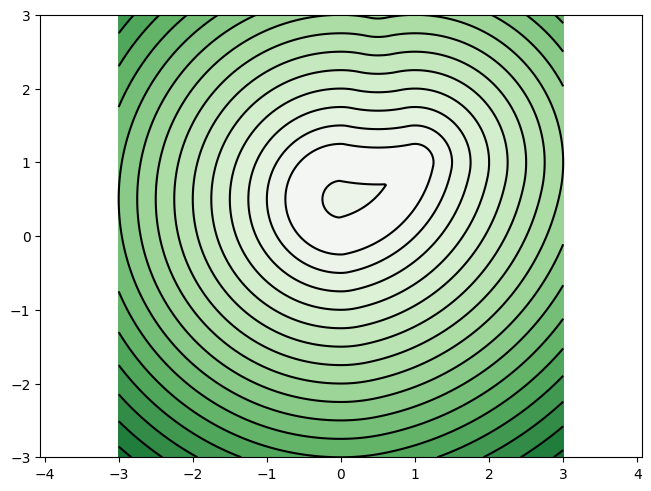

In [10]:
render_distance(bulging_path([
    [[0, 0], [0, 1], 1],
    [[0, 1], [1, 1], -0.1],
    [[1, 1], [0, 0], 0.3],
]))
    